# Sentiment Polarity Prediction Model Analysis Introduction

This notebook analysis various models when used to carry out sentiment analysis on movie reviews. The goal of these sentiment analysis models is to classify a movie review as either positive or negative through document-level sentiment analysis.

The models analysed are:

1. A baseline Multinomial Naive Bayes model
2. A Logistic Regression model
3. A fine-tuned BERT model

Code for a Multinomial Naive Bayes classification model was provided as a baseline model for the previous assignment. As part of that assignment, I took the initial code for this model, refactored it, expanded it and implemented a more stream lined version of this modle which I use in this notebook.

The Logistic Regression model also stems from the previous assignment where as part of that assignment, I was to experiment with different models and parameters to improve on the accuracy of the initial baseline model. This Logistic Regression model was the best model that I experimented with and as a result deserves to be part of this analysis as it is the benchmark model in terms of accuracy.

The new model brought to this analysis is the BERT model. Code for A basic implementation of this model was provided as part of this assignment. This implementation uses the Hugging Face [Transformers](https://huggingface.co/transformers/) library with [PyTorch](https://pytorch.org/) and [Lightning](https://www.pytorchlightning.ai/).

---

All of the models in this notebook are trained on the movie review polarity data of Pang and Lee 2004 [A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts](https://www.aclweb.org/anthology/P04-1035/). The dataset used in this paper is available at http://www.cs.cornell.edu/People/pabo/movie-review-data (section "Sentiment polarity datasets") and contains 1000 positive and 1000 negative reviews, with each review being tokenised, sentence-split (one sentence per line) and lowercased.

In this dataset, each review has been assigned to 1 of 10 cross-validation folds by the authors. In order to compare the results of the different models outlined above, the models are evaluated and compared using an average of the 10-fold cross-validation accuracy scores.

During this process, no special treatment is given to rare or unknown words. Unknown words in the test data are skipped.

# --------------------------------------------------------------------------------------------------------------------------

# Setup

### Packges needed to install

In order to be able to re-implement this work, there are a number of packages you will need to install. The commands for these are as follows:

- conda install numpy
- conda install pandas
- conda install tabulate
- conda install matplotlib
- conda install selenium
- conda install tqdm
- conda install scikit-learn (version > 0.24.0)
- pip install torch==1.7.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
- pip install torchvision==0.8.2+cpu -f https://download.pytorch.org/whl/torch_stable.html
- pip install torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
- pip install transformers
- pip install pytorch-lightning
- pip install pytorch-nlp
- pip install tensorboard

In [1]:
# adjust the torch version below following instructions on https://pytorch.org/get-started/locally/

import sys

# for why we use {sys.executable} see
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

try:
    import torch
except ModuleNotFoundError:
    !{sys.executable} -m pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

try:
    import transformers
except ModuleNotFoundError:
    !{sys.executable} -m pip install transformers

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !{sys.executable} -m pip install pytorch-lightning

try:
    import torchnlp
except ModuleNotFoundError:
    !{sys.executable} -m pip install pytorch-nlp

try:
    import tensorboard
except ModuleNotFoundError:
    !{sys.executable} -m pip install tensorboard

!{sys.executable} -m pip install selenium

     |████████████████████████████████| 2.1MB 6.9MB/s 
     |████████████████████████████████| 901kB 48.5MB/s 
     |████████████████████████████████| 3.3MB 45.7MB/s 
     |████████████████████████████████| 849kB 6.3MB/s 
     |████████████████████████████████| 112kB 14.9MB/s 
     |████████████████████████████████| 829kB 10.1MB/s 
     |████████████████████████████████| 184kB 18.6MB/s 
     |████████████████████████████████| 276kB 18.3MB/s 
     |████████████████████████████████| 1.3MB 21.5MB/s 
     |████████████████████████████████| 143kB 36.9MB/s 
     |████████████████████████████████| 296kB 21.6MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=986fe352d726c2b94a4180d399c0fbef48b52cd626bcf29fc13c48e289243538
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=ee09dc2179fb694496929067026b38

### Import packages

In [2]:
# general packages
import os
import sys
import pandas as pd
import time
from tqdm.auto import tqdm
import numpy as np

In [3]:
# packages for defining the tokeniser
from transformers import AutoTokenizer
from tokenizers.pre_tokenizers import Whitespace

In [4]:
# packages for defining the new trainer
import pytorch_lightning as pl

In [5]:
# traditional models needed for modelling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Packages for BERT tokanisation
import torch
import transformers
import pytorch_lightning as pl
import torchnlp
import tensorboard

### Import the classes and functions from the '.py' files

Instead of having this notebook full of different functions with different applications, I decided to extract these from the notebook and to put them into a '.py' file. I could then read these functions in from the '.py' file without any problem which would enable me to keep this notebook compact and streamlined.

For even more clarity, I have also broken the functions and classes down into three '.py' files. These files correspond to the functions and classes needed to:

1. Load the data
2. Train the Multinomial Naive Bayes model & the Logistic Regression model
3. Train the BERT model

The functions themselves are easily accessible and readable from the '.py' file.

In [6]:
# Load the autoreload extension
%load_ext autoreload
%autoreload 1

In [7]:
# functions for loading the data
%aimport Load_data_functions
import Load_data_functions as ld

In [8]:
# functions for running the Naive Bayes & Logistic Regression models
%aimport Traditional_model_functions
import Traditional_model_functions as tmf

In [9]:
# functions for running the BERT model
%aimport Bert_functions
import Bert_functions as bf

### Increase the maximum number of rows displayed

In [10]:
pd.set_option("display.max_rows", 100)

### Ensure the columns are not truncated and display the full value

In [11]:
pd.set_option('display.max_colwidth', None)

### Define the location of the chromedriver

In this code, I make use of a chromedriver to download the data from the internet. This is only done if the data is not already in your local folder. If you have cloned my original repo then the data will already be in the right place and you won't have to worry about the chromedriver. This data should be in the 'Data' folder.

In [12]:
chromedriver_location = 'chromedriver.exe'

### Define the location of the data folder

In [13]:
data_directory = "Data"

# --------------------------------------------------------------------------------------------------------------------------

# Load in the data

I implemented a nice way to load in the data in the last assignment and it makes sense to use these same functions and the same logic again here in this assignment. The logic behind the below *load_data* function is:

1. Check if you have the data already downloaded and in the right place
    1. If you don't have the data already downloaded, the data will be downloaded from the web and put into the specified data folder
    2. If you have the data already downloaded then continue to step 2
2. Read in all the files in the data
3. Turn this data into a map of cross validation folds and class labels to their associated documents
4. Return this map

---

The resulting output is a dictionary in the following format:

    {(cross validation fold 1, 'pos'): [[list of sentences in doc1], [list of sentences in doc2], ...],
     (cross validation fold 1, 'neg'): [[list of sentences in doc1], [list of sentences in doc2], ...],
     .................................................................................................
     (cross validation fold 10, 'pos'): [[list of sentences in doc1], [list of sentences in doc2], ...],
     (cross validation fold 10, 'neg'): [[list of sentences in doc1], [list of sentences in doc2], ...],
    }

This dictionary has two enteries for each cross validation fold, one for the positive documents and one for the negative documents. Each value in the dictionary then contains a list of documents associated with that cross validation fold and class label pair. Each document in this list is made up of a list of sentences with each sentence, in turn, being made up of a list of tokens.

In [14]:
data_dict = ld.load_data(data_directory, chromedriver_location)

# --------------------------------------------------------------------------------------------------------------------------

# Define the BERT Tokeniser

We must set up a tokeniser for the BERT model. This ensures that the input sentence has been broken up into a sequence of tokens and that these tokens are changed into a numeric representation. When training the model, BERT uses these token sequence numeric represntations to predict the class of a given document.

### Choose which size model to use

There are three model types, which are based on size, the first being tiny, the second being a base model, and the third being a large model. Here, we can select which size we want to proceed with in this modelling.

I decided to use the distilbert model as it was the most reliable and efficient size model to use. The base model and the large model ran out of GPU RAM under a few parameter configurations so for me the logical choice was to use the distilbert model. Despite its smaller size, its accuracy score held up well in comparison to what I saw using the larger models.

In [15]:
model_name = 'distilbert-base-uncased' # tiny
#model_name = 'bert-base-uncased'       # base
#model_name = 'bert-large-uncased'      # large

### Define the tokeniser

When it comes to the tokeniser used with this model, hugging face provides functionality where you can use the same tokeniser for whatever type of model you use. As a result, we can select any size model above without having to download a new tokeniser.

In [16]:
tokeniser = AutoTokenizer.from_pretrained(model_name)

### Decide whether to pre-tokenise the data by splitting on whitespace

We also have the option of selecting to use a pre-tokeniser. This could be used to split up the input sentences into whitespace delimited tokens before they are passed into the tokeniser. Populat BERT libraries can provide tools to help with this.

In the case of our data, the P&L 04 corpus is already tokenised into words and punctuation so this step acrually doesn't matter as there are no whitespace characters in the data. As a result, this parameter will be set to **False** here.

In [17]:
force_whitespace_pre_tokeniser = False

if force_whitespace_pre_tokeniser:
    tokeniser.pre_tokenizer = Whitespace()

# --------------------------------------------------------------------------------------------------------------------------

# Test the Tokeniser on Example Input

In this section, I will show the steps that this tokeniser does on an example input. You will see that the tokenisation process involves:

1. Splitting the sentence into tokens
2. Adding a start and end token to the sentence to specify these positions - [CLS] & [SEP] respectively
3. Mapping each token in the sentence to a unique numeric encoding to be used in the BERT model

In [18]:
# Define a pre-tokenised input document
example_batch = [['hello', 'world', '!'],
                 ["tokenisation", "'s", "fun"],
                ]

In [19]:
bf.print_token_summary_of_pretokenised_sentences(tokeniser, example_batch)

|    |   sentence_num |   input_ids | tokens   |   word_ids |
|---:|---------------:|------------:|:---------|-----------:|
|  0 |              0 |         101 | [CLS]    |        nan |
|  1 |              0 |        7592 | hello    |          0 |
|  2 |              0 |        2088 | world    |          1 |
|  3 |              0 |         999 | !        |          2 |
|  4 |              0 |         102 | [SEP]    |        nan |


|    |   sentence_num |   input_ids | tokens    |   word_ids |
|---:|---------------:|------------:|:----------|-----------:|
|  0 |              1 |         101 | [CLS]     |        nan |
|  1 |              1 |       19204 | token     |          0 |
|  2 |              1 |        6648 | ##isation |          0 |
|  3 |              1 |        1005 | '         |          1 |
|  4 |              1 |        1055 | s         |          1 |
|  5 |              1 |        4569 | fun       |          2 |
|  6 |              1 |         102 | [SEP]     |        nan

In [20]:
bf.print_encoding_of_pretokenised_sentences(tokeniser, example_batch)

|    | token   | encoding   |
|---:|:--------|:-----------|
|  0 | hello   | [7592]     |
|  1 | world   | [2088]     |
|  2 | !       | [999]      |


|    | token        | encoding      |
|---:|:-------------|:--------------|
|  0 | tokenisation | [19204, 6648] |
|  1 | 's           | [1005, 1055]  |
|  2 | fun          | [4569]        |




You will notice from the above outputs that in some cases, the tokeniser tokenises words even further than was done in the corpus loaded into this notebook. This is particularly evident in the outputs for the second example sentence where *'tokenisation'* gets turned into *'token'* and *'##isation'*. As a result of this, the token *'tokenisation'* gets mapped to two numeric encodings, one for each of its sub tokens.

# --------------------------------------------------------------------------------------------------------------------------

# Analyse the Distribution of Sequence Length Across the Documents

The BERT models that have been made available to the public have only been trained up to a length of 512 subword units as memory requirements increase quadratically with the sequence length.

In this section, I set out to anayse the number of tokens in each of the documents to get a feel for how the documents are distributed based on their length. This will enable me to see how much information would be lost in the case of the 512 subword unit restriction and how to proceed with implementing the BERT model based on this information.

### Set the bin width of this distrbution

The below bin width parameter specifies the width of the document length bins to put the documents into. In our case, we will specify **256** as this parameter value as this is half of the maximum sequence length of the model and will enable us to get a better feel for the document length distributions.

In [21]:
bin_width = 256

### Create a table of the documents distribution

In [22]:
distribution, max_length_bin = bf.get_distribution_of_document_lengths(data_dict, tokeniser, bin_width)

Token indices sequence length is longer than the specified maximum sequence length for this model (926 > 512). Running this sequence through the model will result in indexing errors


In [23]:
bf.print_doc_breakdown_of_bins(distribution, bin_width, max_length_bin)

|    | Bin_length   |   pos |   neg |   total |
|---:|:-------------|------:|------:|--------:|
|  0 | 0 -> 255     |     7 |    16 |      23 |
|  1 | 256 -> 511   |   133 |   152 |     285 |
|  2 | 512 -> 767   |   284 |   339 |     623 |
|  3 | 768 -> 1023  |   277 |   288 |     565 |
|  4 | 1024 -> 1279 |   155 |   125 |     280 |
|  5 | 1280 -> 1535 |    78 |    46 |     124 |
|  6 | 1536 -> 1791 |    32 |    19 |      51 |
|  7 | 1792 -> 2047 |    18 |     8 |      26 |


As you can see from the above distribution table, only **15.5%** of the documents have document lengths less than 512 tokens. As a result of this alongside the constraints of the model, we will not be able to consider the document as a whole and instead will have to use a subset of the document. This subset, which will have a maximum sequence length of *(512)*, limits the amount of information that is available to us from each document.

# --------------------------------------------------------------------------------------------------------------------------

# Create Training-Test Splits for Cross-Validation

This is where we split the loaded dataset into train and test splits. In this dataset, there are 1000 positive documents and 1000 negative documents and we must split these 2000 documents into 10 different cross validation splits. This gives an 1800-200 train-test split for each of the 10 cross validation folds.

In [24]:
train_test_splits = ld.get_train_test_splits(data_dict)

### Show the splits

We can visualise the number of documents in each cross validation fold.

In [25]:
ld.count_docs_in_train_test_split(train_test_splits)

,train_set_size,test_set_size
0,1800,200
1,1800,200
2,1800,200
3,1800,200
4,1800,200
5,1800,200
6,1800,200
7,1800,200
8,1800,200
9,1800,200


# --------------------------------------------------------------------------------------------------------------------------

# Test the Slicing of Documents to the specified BERT Sequence Length

Here we will test out how the documents will be distributed when we subset them to the maximum specified sequence length on one of the cross validation fold.

### Set the maximum sequence length to put into our BERT model

This parameter specifies the maximum sequence length that the documents will be subset to before they are fed into the BERT model. While this maximum specified length must be less than 512, as the BERT model cannot deal with any sequence with a greater length, its value can be changed to whatever value less than 512 that you choose.

This parameters value is usually set to a number with base 2. Each increment in this value comes with a significant increase in the resource requirments to run the code and as a result, its value may need to be restricted to reflect the GPU you have available to you. The fine-tuning of BERT is where the process becomes the most memory intensive.

As I have Google Collab Pro, I figured that I would be able to run my BERT model using the full sequence length of 512, however, when I ran the code using this maximum sequence length, I ran into the following error:

    RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 15.90 GiB total capacity; 14.79 GiB already allocated; 215.75 MiB free; 14.81 GiB reserved in total by PyTorch)

This told me that the GPU I had access to at that time did not have enough memory to use all 512 tokens. For this reasons, I have chosen to restrict the model to a maximum sequence length of **256**.

In [26]:
max_sequence_length = 256

### Select which cross validation fold to use in this test

It makes sense to just use the first cross validation fold in this test, however, this parameter may be experimented with to see the results across the other folds.

In [27]:
cv_num = 0
cv_0_training_data = train_test_splits[cv_num][0]

### Specify how the sequence will be distributed across the start & end of the documents

If we specify 512 tokens as our maximum specified length, there are a number of ways this subset of 512 tokens can be selected from the documents, these are:
1. Using the first 512 tokens in the document
2. Using the last 512 tokens in the document
3. Combining a mix of the start tokens and the end tokens to form one list of tokens of length 512

We can actually specify how we want these tokens to be selected from the documents using the below *start_end_fraction* parameter. This parameter specifies what proportion of the tokens in the final sequence to take from the start, with the rest of the tokens being taken from the end of the sequence.

Eg. if:

    start_end_fraction = 1   -->  we take all tokens from the start of the document
    start_end_fraction = 0.5 -->  the tokens selected are split evenly between the start and the end
    start_end_fraction = 0   -->  we take all tokens from the end of the document

In [28]:
start_end_fraction = 0.25

### Create a summary table and a distribution table of the documents after they are sliced

In [29]:
sliced_doc_summary_df, length_to_count_map = bf.test_document_slicer_on_train_test_split(cv_0_training_data, tokeniser, start_end_fraction, max_sequence_length)

There are 1800 training documents in this cross validation fold


#### Output the sliced document summary

This shows how the tokens in the first 10 documents were distributed according to the above *start_end_fraction* parameter.

In [30]:
sliced_doc_summary_df

,doc_idx,seq_len,num_tokens_from_start,num_tokens_from_end,total_tokens
0,0,256,58,171,229
1,1,256,59,175,234
2,2,256,58,170,228
3,3,256,50,169,219
4,4,256,61,176,237
5,5,256,59,156,215
6,6,256,60,167,227
7,7,256,50,177,227
8,8,256,56,177,233
9,9,256,53,165,218


#### Output the distribution of each document sequence length

This shows the number of documents with each document length once this document slicing has been completed.
We should see the majority of documents having a length qual too the specified *'max_sequence_length'* parameter.

In [31]:
print('Frequency of each sequence length (document length --> # docs):')
for length in sorted(list(length_to_count_map.keys())):
    print(length, "-->", length_to_count_map[length])

Frequency of each sequence length (document length --> # docs):
53 --> 1
243 --> 1
254 --> 5
255 --> 35
256 --> 1758


# --------------------------------------------------------------------------------------------------------------------------

# Train a BERT classifier on each CV fold

Now that I have tested how the document sequences are selected, it is time to see how the BERT model performs when trained on each of the cross validation folds.
As this is how the Multinomial Naive Bayes model and the Logistic Regression model were evaluated, an independent BERT model will be trained on each of the cross validation folds to produce a model accuracy score. The accuracy scores from each of these models will then be averaged to obtain an overall accuracy score for the BERT model. We can then accurately compare these accuracy scores across the different models.

### Set the hyperparameters used in the BERT classifier

There are a number of hyper parameters that we need to set when running this model. These parameters are used to configure the model to a way that best suits the data we are using and our application. Some of these parameters define important things like the model learning rate and batch size.

These parameters must be set carfully as they directly effect the models performance and the computational requirments needed to run these models. In the case of the batch size, inceses in this paramter result in a linear increase in the memory requirments of the model.

While ideally we would like a batch size of 16 or 32 for efficient training, I have decided to select a batch size of 10 as this only requirs 12GB of GPU RAM. This is important as the GPU available only has 15GB RAM available.
An increase to batch_size = 16, gives:

    RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 15.90 GiB total capacity; 14.62 GiB already allocated; 87.75 MiB free; 14.94 GiB reserved in total by PyTorch)

In [32]:
batch_size = 10

classifier_hyperparams = {# Encoder specific learning rate
                          "encoder_learning_rate": 1e-05,

                          # Classification head learning rate
                          "learning_rate": 3e-05,

                          # Number of epochs we want to keep the encoder model frozen
                          "nr_frozen_epochs": 3,

                          # How many subprocesses to use for data loading - 0 means data is loaded in the main process
                          "loader_workers": 4,

                          # Number of GPUs you have available
                          "gpus": 1,

                          # Number of documents used in each iteration of the model
                          "batch_size": batch_size,
                         }

### Set the other parameters needed to train the model

There are other parameters we can specify when training the model. These parameters are more general than the above hyperparameters.

For instance, the *max_epochs* and the *model_patience* revolve around how many iterations the model does over the data. This value correlates directly to how long the model takes to train as the higher these numbers are, the more iterations needed and hence the more time the model will take.
In this model, I have chosen to set the maximum number of epochs to **10**. This enables me to keep the time it takes to train the model to a minimum while also giving a reasonable amount of iterations for the BERT model to still be accurate.

The *start_end_fraction* parameter is also specified here again. This parameter details how the tokens are extracted from the documents. This can have big implications on the model as we want to select a split where we maintain the majority of the sentiment details.
Here, I have set this parameter to favour the end of the document as I felt the majority of the documents sentiment would come at the end of the review as the writer summed up their feelings. I have gone with an split of taking 20% of the tokens from the start and 80% from the end as a result.

In [33]:
model_params = {# Number of iterations the model does over the dataset
                "max_epochs": 10,

                # proportion of the tokens in the final sequence to take from the start of the document
                "start_end_fraction": 0.2,  # set to 0.0001 to duplicate short documents

                # The Pre-Processing Batch size
                "preproc_batch_size": 8,

                # Maximum number of epochs to allow the model to have without accuracy improvement
                "model_patience": 5,

                # Minimum change in accuracy the model should have
                "min_early_stopping_delta": 0.0,
               }

### Put the predefined variables in a dictionary to be used when training the classifiers

These are parameters that I have defined in the above code for various reasons that are also needed to define the classification model.

In [34]:
predefined_variables = {"model_name": model_name,
                        "tokeniser": tokeniser,
                        "max_sequence_length": max_sequence_length,
                       }

### Define a BERT classifier and a trainer for each CV fold using the above parameters

I have stored all of the above defined parameters in a dictionaroes as it enables me to pass a only a few parameters to my defined function when defining the classification models. These values can then be accessed and unpacked inside this function.

This function iterates through each cross-validation fold and creates a classifier and a model trainer for each of these. It also creates a model callback for each cross-validation which stores the values for the best model trained across all the epochs.

In [37]:
classifiers_list, trainers_list, modeL_callbacks_list = bf.define_classifier_and_trainer_for_each_cv_fold(train_test_splits, classifier_hyperparams, model_params, predefined_variables)

Defining the classifiers for each CV fold:



Defining the trainers for each CV fold:


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


### Fit the defined classifiers to the data

Once these classifiers and trainers have been defined, it is time to train the models using them. Each item in these lists corrosponds to one of the cross-validation folds so we can iterate through these lists, train the model and then calculate a few evalutaion metrics for each fold. These metrics attempt to shed light on the models performance across each of the cross-validation folds.

There are two tables returned by the below function, the details of these are as follows:
1. Overall run evaluation table
    * This table contains the aggregated evaluation scores across all of the 10 cross validation folds
    * Starting with a list of the accuracy scores, we can get the average and the variance of these scores to give an overall measure of the model

2. Fold evaluation table
    * This table contains the models scores for each of the cross validation fold seperately.
    * This includes:
        - The time it took to train the model
        - The models validation accuracy
        - The models test accuracy
        - The models loss on the test seperate

These tables can then be analysed through plots or other techniques to measure the models capabilities and overall performance.

Note: Due to the way this model is set up as opposed to the traditional models, we have a validation accuracy along with a test accuracy score. The validation accuracy score was recorded during training while the test accuracy is obtained through a seperate test after the model is trained.

In [38]:
bert_eval_df, bert_fold_eval_df = bf.train_classifiers(model_name, classifiers_list, trainers_list, modeL_callbacks_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params
---------------------------------------------------------
0 | bert                | DistilBertModel  | 66.4 M
1 | classification_head | Sequential       | 1.6 M 
2 | _loss               | CrossEntropyLoss | 0     
---------------------------------------------------------
1.6 M     Trainable params
66.4 M    Non-trainable params
67.9 M    Total params
271.752   Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params
---------------------------------------------------------
0 | bert                | DistilBertModel  | 66.4 M
1 | classification_head | Sequential       | 1.6 M 
2 | _loss               | CrossEntropyLoss | 0     
---------------------------------------------------------
1.6 M     Trainable params
66.4 M    Non-trainable params
67.9 M    Total params
271.752   Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params
---------------------------------------------------------
0 | bert                | DistilBertModel  | 66.4 M
1 | classification_head | Sequential       | 1.6 M 
2 | _loss               | CrossEntropyLoss | 0     
---------------------------------------------------------
1.6 M     Trainable params
66.4 M    Non-trainable params
67.9 M    Total params
271.752   Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params
---------------------------------------------------------
0 | bert                | DistilBertModel  | 66.4 M
1 | classification_head | Sequential       | 1.6 M 
2 | _loss               | CrossEntropyLoss | 0     
---------------------------------------------------------
1.6 M     Trainable params
66.4 M    Non-trainable params
67.9 M    Total params
271.752   Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params
---------------------------------------------------------
0 | bert                | DistilBertModel  | 66.4 M
1 | classification_head | Sequential       | 1.6 M 
2 | _loss               | CrossEntropyLoss | 0     
---------------------------------------------------------
1.6 M     Trainable params
66.4 M    Non-trainable params
67.9 M    Total params
271.752   Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params
---------------------------------------------------------
0 | bert                | DistilBertModel  | 66.4 M
1 | classification_head | Sequential       | 1.6 M 
2 | _loss               | CrossEntropyLoss | 0     
---------------------------------------------------------
1.6 M     Trainable params
66.4 M    Non-trainable params
67.9 M    Total params
271.752   Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params
---------------------------------------------------------
0 | bert                | DistilBertModel  | 66.4 M
1 | classification_head | Sequential       | 1.6 M 
2 | _loss               | CrossEntropyLoss | 0     
---------------------------------------------------------
1.6 M     Trainable params
66.4 M    Non-trainable params
67.9 M    Total params
271.752   Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params
---------------------------------------------------------
0 | bert                | DistilBertModel  | 66.4 M
1 | classification_head | Sequential       | 1.6 M 
2 | _loss               | CrossEntropyLoss | 0     
---------------------------------------------------------
1.6 M     Trainable params
66.4 M    Non-trainable params
67.9 M    Total params
271.752   Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params
---------------------------------------------------------
0 | bert                | DistilBertModel  | 66.4 M
1 | classification_head | Sequential       | 1.6 M 
2 | _loss               | CrossEntropyLoss | 0     
---------------------------------------------------------
1.6 M     Trainable params
66.4 M    Non-trainable params
67.9 M    Total params
271.752   Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params
---------------------------------------------------------
0 | bert                | DistilBertModel  | 66.4 M
1 | classification_head | Sequential       | 1.6 M 
2 | _loss               | CrossEntropyLoss | 0     
---------------------------------------------------------
1.6 M     Trainable params
66.4 M    Non-trainable params
67.9 M    Total params
271.752   Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (5) or minimum steps (None) has not been met. Training will continue...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


# --------------------------------------------------------------------------------------------------------------------------

# Save Each Folds Best Model Outside the Logs

During the training process, a lot of models are saved in files and can be read back in again. However, of all these models, we only want the best model. As there are so many of these models which do not concern us, this step aims to extract the best trained model for each cross validation fold and to save them seperately to the other models, outside of the training logs.

This step also allows us to save a copy of these models without the training state of the Adam optimiser, training parameters, and filesystem paths. This helps to save memory.

The below function saves a number of versions of the file, these being:
1. A version containing absolute paths and training parameters
2. A version saving only the weights
3. A version saving the bert model in pytorch format and without the classification head
4. A version saving the full network in pytorch format

Note: The `.ckpt` files are zip files containing a [pickle](https://docs.python.org/3/library/pickle.html) file, version information and various binary files.

In [42]:
for i, model_callback in enumerate(tqdm(modeL_callbacks_list)):
    
    # save the best model for this fold
    bf.save_best_model(model_name, batch_size, model_callback.best_model_path, fold_num=i)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


# --------------------------------------------------------------------------------------------------------------------------

# Load in the Best Models for each fold

Once the best models have been saved outside the logs, we can go about reading these best models back in to be analysed. This analysis will take the form of assessing the models ability to accurately predict the sentiment label of a given document.

This step creates a list of the best models for each cross validation fold.

In [43]:
fold_best_models_list = []
for fold_num in tqdm(range(len(modeL_callbacks_list))):

    # get the best model
    fold_best_model = bf.load_best_model(tokeniser, fold_num)

    # add this to a list of the best model for each fold
    fold_best_models_list.append(fold_best_model)

# --------------------------------------------------------------------------------------------------------------------------

# Test the Models Predictions - Sample Data

### Define a new trainer

To generate these predictions, we need a new trainer. The below defined trainer will be used in this sample prediction case and the later prediction case for each fold.

In [44]:
new_trainer = pl.Trainer(gpus=-1, logger=pl.loggers.TensorBoardLogger(os.path.abspath('lightning_logs')))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


### Define sample test documents

In the dataset, documents are lists of sentences and each sentence is a list of tokens. Therefore, when defining our sample data for testing, we must define it in this way.

We will define two documents, one positive and one negative, for our test to test the models ability to predict blatantly obvious documents.

In [ ]:
mini_test_dataset  = [# document 1
                      ([['This', 'movie', 'is', 'great', '.'], ['So', 'much', 'fun', '.']], 'pos'),
                      # document 2
                      ([['What', 'a', 'waste', 'of', 'time', '.'], ['Never', 'seen', 'anything', 'this', 'bad', '.']], 'neg'),
                     ]

### Define which cross validation model to use

When running this test, for simplicity, I will use the best model for the first cross validation.

In [144]:
best_model = fold_best_models_list[0]

### Generate predictions for the test data using the defined model

The below function take in some test data, slices it into a sequence of managable length, puts it into batches, and then tests the model on this batched test data. The predictions for each document are stored in place in the model and will be analysed in the next cell.

In [145]:
sliced_mini_test_dataset = bf.test_best_model_on_test_data(new_trainer, tokeniser, max_sequence_length, model_params["start_end_fraction"], best_model, mini_test_dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 1.0, 'test_loss': 0.0006215724279172719}
--------------------------------------------------------------------------------


### Analyse these predictions

Here we analyse the predictions of the model for our given mini test set. The below function created a table containing the documents real sentiment class, the predicted class, whether the model was correct, and then the document itself.

In the case when the document contains two parts, one from the start and one from the end, these are seperated by a double pipe ('||') when displayed in the *'tested_document'* column.

In [146]:
# get the models predictions
mini_prediction_df = bf.get_models_prediction_results(best_model, sliced_mini_test_dataset)
mini_prediction_df

,index,real_class,predicted_class,correct,tested_document
0,0,pos,pos,yes,This movie is great . So much fun .
1,1,neg,neg,yes,What a waste of time . Never seen anything this bad .


As you can see from the above table, the BERT model was easily able to predict the correct class of these documents. While the class of these documents was pretty obvious, this small test is a proof of concept to how the test will work on the full test data for each fold.

# --------------------------------------------------------------------------------------------------------------------------

# Generate the Best Models Predictions For Each Folds Documents

To now test the models predictions on the full dataset, we can iterate through each train-test split, format the data, test the best model for that fold on this data, get the results on this prediction and then create a table of these results. This table contains:
* The document index
* The documents sentiment label
* The models predicted sentiment label for the document
* The document itself

The results table for each fold can be stored in a list with each entry corresponding to the models predictions for one cross validation fold. This list can then be examined to see the strengths and weaknesses of the BERT model.


In [46]:
all_fold_bert_prediction_dfs = []
for fold_train_test_split, fold_best_model in tqdm(zip(train_test_splits, fold_best_models_list)):
    
    # get the test dataset
    fold_test_dataset = fold_train_test_split[-1]
    
    # test the model
    sliced_fold_test_dataset = bf.test_best_model_on_test_data(new_trainer, tokeniser, max_sequence_length, model_params["start_end_fraction"], fold_best_model, fold_test_dataset)
    
    # get the results of the test for each document
    fold_prediction_df = bf.get_models_prediction_results(fold_best_model, sliced_fold_test_dataset)
    
    # add the results to a list of prediction dfs over all the folds
    all_fold_bert_prediction_dfs.append(fold_prediction_df)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9049999117851257, 'test_loss': 0.4320180118083954}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8500000238418579, 'test_loss': 0.32092663645744324}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9149999618530273, 'test_loss': 0.19362886250019073}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8649999499320984, 'test_loss': 0.3091205060482025}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8250001072883606, 'test_loss': 0.38094666600227356}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8749999403953552, 'test_loss': 0.2921234965324402}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8350000381469727, 'test_loss': 0.38909950852394104}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8849998712539673, 'test_loss': 0.30013203620910645}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8649999499320984, 'test_loss': 0.322293758392334}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8949999213218689, 'test_loss': 0.28064295649528503}
--------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------

# Define & Train the Traditional Models

This is where we bring in the models from the previous assignment. These models are not neural based so I have coined them *'traditional'* models.

The Multinomial Naive Bayes model here is the baseline model supplied for assignment 2 and the Logistic Regression model is the best model that I found for this classification task during assignment 2.

The process for training these models is quite short in comparison to the above process used for the BERT model.

This process will train a model for each fold and test it to get some evaluation metrics. These evaluation metrics along with the models predictions for each document are returned to be used later in the notebook for analysis.

In [47]:
traditional_model_map = {"Multinomial Naive Bayes": tmf.Model(model=MultinomialNB()),
                         "Logistic Regression": tmf.Model(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)),
                        }

In [102]:
trad_model_summary_eval_df = pd.DataFrame()
model_fold_eval_dfs_list, model_fold_predictions_list = [], []
for trad_model_name, model in traditional_model_map.items():
    print("\nEvaluating the {} model".format(trad_model_name))

    # evaluate the model
    model_summary_eval_df, model_fold_eval_df, doc_fold_predictions = tmf.evaluate_model(model, trad_model_name, train_test_splits, fold_verbose=True)

    # save the model fold evaluation scores
    model_fold_eval_dfs_list.append(model_fold_eval_df)

    # save the model summary evalutaion scores
    trad_model_summary_eval_df = pd.concat([trad_model_summary_eval_df, model_summary_eval_df], axis=0).reset_index(drop=True)

    # save the models predictions and the documents associated with them
    model_fold_predictions_list.append(doc_fold_predictions)


Evaluating the Multinomial Naive Bayes model
   Fold 1 - 3 seconds --> Accuracy score = 0.805
   Fold 2 - 3 seconds --> Accuracy score = 0.835
   Fold 3 - 3 seconds --> Accuracy score = 0.84
   Fold 4 - 3 seconds --> Accuracy score = 0.82
   Fold 5 - 3 seconds --> Accuracy score = 0.835
   Fold 6 - 3 seconds --> Accuracy score = 0.825
   Fold 7 - 3 seconds --> Accuracy score = 0.845
   Fold 8 - 3 seconds --> Accuracy score = 0.835
   Fold 9 - 3 seconds --> Accuracy score = 0.785
   Fold 10 - 3 seconds --> Accuracy score = 0.855

Evaluating the Logistic Regression model
   Fold 1 - 48 seconds --> Accuracy score = 0.845
   Fold 2 - 41 seconds --> Accuracy score = 0.875
   Fold 3 - 32 seconds --> Accuracy score = 0.855
   Fold 4 - 43 seconds --> Accuracy score = 0.86
   Fold 5 - 46 seconds --> Accuracy score = 0.86
   Fold 6 - 40 seconds --> Accuracy score = 0.88
   Fold 7 - 34 seconds --> Accuracy score = 0.865
   Fold 8 - 36 seconds --> Accuracy score = 0.885
   Fold 9 - 29 seconds -->

# --------------------------------------------------------------------------------------------------------------------------

# Analyse the model accuracy scores

This is the section where we get into the heart of the assignment and analyse the strengths and weaknesses of each of these models along with their similarities and differences.

You will recall that, from the above code, for each of these models, we have obtained a summary evaluation dataframe, an evaluation dataframe with the metrics for each cross validation, and a number of dataframes containing the predictions made by this model for the documents in each cross validation fold.

These tables can be leveraged through insightful analysis to help us compare these models.

### Analyse the model evaluation summary scores

First we will look at the model evaluation summaries. The values in these tables are aggregations of the values obtained from each cross validation fold.

In [103]:
trad_model_summary_eval_df

,Full Name,Avg Accuracy,Accuracy Std Dev,Min Accuracy,Max Accuracy,Total Time (s),All Fold Averages
0,Multinomial Naive Bayes,0.8280,0.019391,0.785,0.855,29.61,"[0.805, 0.835, 0.84, 0.82, 0.835, 0.825, 0.845, 0.835, 0.785, 0.855]"
1,Logistic Regression,0.8675,0.019653,0.840,0.910,390.71,"[0.845, 0.875, 0.855, 0.86, 0.86, 0.88, 0.865, 0.885, 0.84, 0.91]"


In [50]:
bert_eval_df

,Full Name,Avg Test Accuracy,Avg Val Accuracy,Test Accuracy Std Dev,Val Accuracy Std Dev,Min Test Accuracy,Max Test Accuracy,Min Val Accuracy,Max Val Accuracy,Total Time (s),All Fold Test Accuracies,All Fold Val Accuracies
0,distilbert-base-uncased,0.8715,0.87,0.027933,0.033628,0.825,0.915,0.822222,0.938889,2396.08,"[0.905, 0.85, 0.915, 0.865, 0.825, 0.875, 0.835, 0.885, 0.865, 0.895]","[0.939, 0.883, 0.844, 0.917, 0.856, 0.85, 0.872, 0.822, 0.844, 0.872]"


While we knew from the previous assignment that the Logistic Regression model was much better than the baseline Multinomial Naive bayes model, these tables shows us that the BERT model performs even better than both models in almost all metrics.

As you would expect, BERT's validation accuracy is higher than its test accuracy. However, the difference in these scores is quite minimal and not as large as I expected. This shows that the model was trained well and did not overfit during training.

We can get some more detailed insight into how these models performed over the cross validation folds through the lists in these tables, but this is not easy to piece together and we will dive into more when we look at the fold dataframes.

There is not too much this summary tells us other than that BERT outperforms the other models showing the masking approach and neural networks are a better method of classifying sentiment for this particular task. This finding falls in line with our previous understanding of sentiment analysis of natural language.

### Analyse the fold evaluations

Now that we have assertained that BERT performs better than the other models, it is important to also see how they compare on the individual folds and not just overall.

To do this, we can plot the evaluation metrics in a graph as a line plot across the folds. We will plot three graphs,
1. The time each model took
2. The test accuracy of each model
3. The validation & test accuracy of the BERT model

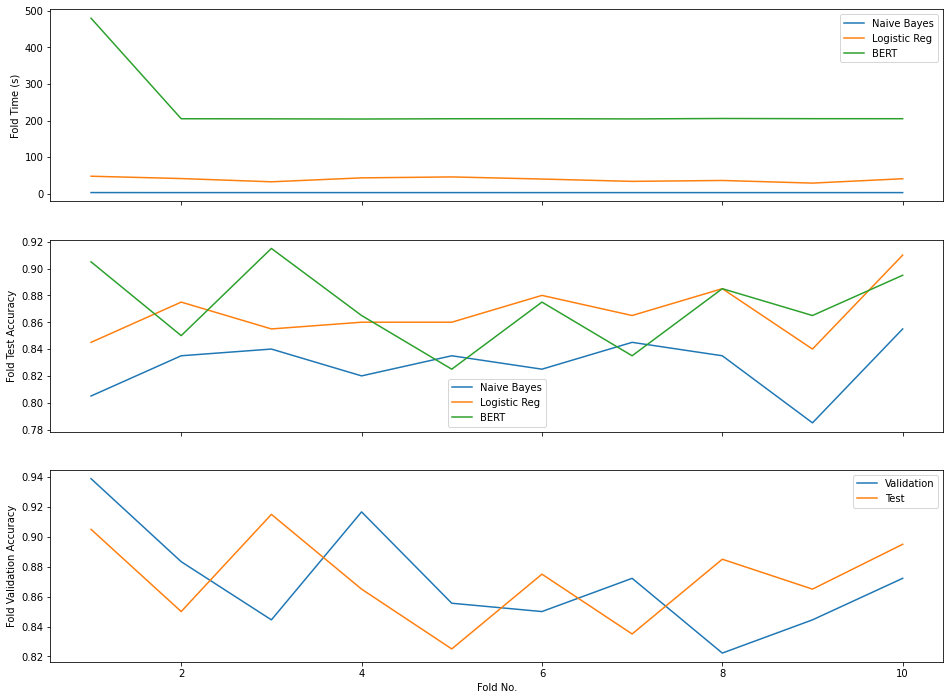

In [104]:
nb_fold_eval_df, lr_fold_eval_df = model_fold_eval_dfs_list
bf.plot_each_models_evaluation_metrics(nb_fold_eval_df, lr_fold_eval_df, bert_fold_eval_df)

First adressing the time, what is immediately evident is that the BERT model takes much longer to train, taking 200 seconds as opposed to the ~70 seconds the other models take.

From the test accuracy scores, we can actually see that the BERT model was much less consitent over the folds than the other models. It was really good at classifying documents in some folds, like 1 & 3, but did worse than the Naive Bayes model in others, like 5 & 7. While it also did well in fold 10, the other models also preformed quite well in this fold so it's performance was not out of the ordinary.
We also see some cases where the performance of the Logistic Regression model and the Naive Bayes model was poor in comparison to their values on other folds, but where the BERT models accuracy held up better.
In the next section, I will explore some of these cases to get a deeper understanding.

The final graph shows the validation Accuracy and the test accuracy for the BERT model. As noted above, these values were quite similar in the end showing that the validation set using in training was a good representation of the test set. We see that as the the test accuracy increases, we see a drop in validation accuracy and vice versa. This seems to balance at around 87% which was in the end the average over accuracy score for this model.

# --------------------------------------------------------------------------------------------------------------------------

# Analyse the models predictions

Building on from the previous section, this section looks in more detail at the predictions made by the models and attempts to figure out why the model predicted a specific label for a class.

As noted in the above fold analysis, there are a number of folds which the BERT model performs either far better or much worse, on a relative scale, when compared to the other models.

In this section, I will dive into the documents being classified in these specific folds to investigate exactly why this is the case. By doing this, I hope to identify the strengths and weaknesses of these different models.

In [105]:
# extract the naive bayes & logistic regression document predictions
all_fold_nb_prediction_dfs, all_fold_lr_prediction_dfs = model_fold_predictions_list

### Fold 0

First I will look at fold 0. I have chosen this fold as the accuracy scores from the above graph had the highest variance between the three models. From the graph, we can see that the BERT model had a test accuracy of over 90% while the Naive Bayes model had a test accuracy score under 80%. The Logistic Regression model then lay in the middle of the two with a test accuracy of about 85%. I felt this was worth digging into.

In [106]:
exp1_fold_num = 0

In [107]:
exp1_bert_fold_pred_df = all_fold_bert_prediction_dfs[exp1_fold_num]
exp1_nb_fold_pred_df = all_fold_nb_prediction_dfs[exp1_fold_num]
exp1_lr_fold_pred_df = all_fold_lr_prediction_dfs[exp1_fold_num]

#### See the breakdown of the correct/incorrect predictions

We can first break the documents into two groups, the correctly classified documents and the incorrectly classifier documents.

In [108]:
print("BERT Predictions:")
exp1_bert_correct_pred_df, exp1_bert_incorrect_pred_df = bf.get_correct_and_incorrect_predictions(exp1_bert_fold_pred_df)

print("\nNaive Bayes Predictions:")
exp1_nb_correct_pred_df, exp1_nb_incorrect_pred_df = bf.get_correct_and_incorrect_predictions(exp1_nb_fold_pred_df)

print("\nLogistic Regression Predictions:")
exp1_lr_correct_pred_df, exp1_lr_incorrect_pred_df = bf.get_correct_and_incorrect_predictions(exp1_lr_fold_pred_df)

BERT Predictions:
90% of these documents are predicted correctly
10% of these documents are predicted incorrectly

Naive Bayes Predictions:
80% of these documents are predicted correctly
20% of these documents are predicted incorrectly

Logistic Regression Predictions:
84% of these documents are predicted correctly
16% of these documents are predicted incorrectly


We can see once we do this that the breakdown is, as expected, in line with the stated accuracy scores for these models.

#### See the breakdown of the classes of the correctly classified documents

We can break this down further again and have a look at how the positive and negative documented are distributed in the group of correctly classified documents.

In [109]:
print("BERT Correct Predictions:")
exp1_bert_correct_pos_docs, exp1_bert_correct_neg_docs = bf.get_pos_and_neg_docs(exp1_bert_correct_pred_df)

print("\nNaive Bayes Correct Predictions:")
exp1_nb_correct_pos_docs, exp1_nb_correct_neg_docs = bf.get_pos_and_neg_docs(exp1_nb_correct_pred_df)

print("\nLogistic Regression Correct Predictions:")
exp1_lr_correct_pos_docs, exp1_lr_correct_neg_docs = bf.get_pos_and_neg_docs(exp1_lr_correct_pred_df)

BERT Correct Predictions:
48% of these documents are positive
52% of these documents are negative

Naive Bayes Correct Predictions:
48% of these documents are positive
52% of these documents are negative

Logistic Regression Correct Predictions:
50% of these documents are positive
50% of these documents are negative


We can see from this that the number of positive and negative documents being correctly classified is fairly evenly distributed. This tells us that all classifiers are indeed able to accurately classify documents from either class and that there is not a significant bias towards correctly labelling one class.

#### See the breakdown of the classes of the incorrectly classified documents

We can do the same breakdown for the incorrectly classified documents.

In [110]:
print("BERT Incorrect Predictions:")
exp1_bert_incorrect_pos_docs, exp1_bert_incorrect_neg_docs = bf.get_pos_and_neg_docs(exp1_bert_incorrect_pred_df)

print("\nNaive Bayes Incorrect Predictions:")
exp1_nb_incorrect_pos_docs, exp1_nb_incorrect_neg_docs = bf.get_pos_and_neg_docs(exp1_nb_incorrect_pred_df)

print("\nLogistic Regression Incorrect Predictions:")
exp1_lr_incorrect_pos_docs, exp1_lr_incorrect_neg_docs = bf.get_pos_and_neg_docs(exp1_lr_incorrect_pred_df)

BERT Incorrect Predictions:
74% of these documents are positive
26% of these documents are negative

Naive Bayes Incorrect Predictions:
59% of these documents are positive
41% of these documents are negative

Logistic Regression Incorrect Predictions:
48% of these documents are positive
52% of these documents are negative


Unlike with the correctly classified documents, we can see a bit of variation here.

The breakdown of positive and negative documents for the Naive Bayes model and the Logistic Regression model have still remained quite even, however, the BERT model has a significant difference in the breakdown of documents.

While the BERT model has less incorrectly classified documents which may skew these percentages, this is still a significant difference. I susepct that the documents it correctly classified, that the other models didn't, may have been negative documents which has left the number of positive documents relative to the negative documents inflated. This may also be the reason why the BERT model got a better accuracy score for this fold.

#### Look deeper into the incorrectly classified positive documents

We will now look deeper at these incorrectly classified documents to try understand better why this might have been the case. To limit the scope of this analysis, we will only look at the top documents for each models.

As the BERT model only takes in sequences to a maximum length of 512 tokens, these documents will naturally contain only a subset of the information in the document as a while. However, the other models are capable of taking the full document in.

While we will not directly compare the same document across all the models, we will look at a number of different documents and how they were classified.

##### BERT's Predictions

In [117]:
exp1_bert_incorrect_pos_docs.head(1)

,index,real_class,predicted_class,correct,tested_document
5,101,pos,neg,no,"every now and then a movie comes along from a suspect studio , with every indication that it will be a stinker , and to everybody's surprise ( perhaps even the studio ) the film becomes a critical darling . mtv films' _election , a high school character gets going , like in her fantastic speech in the gymnasium , then you're won over . one thing that's been bothering me since i've seen it . there is an extraordinary amount of sexuality in this film . i suppose that , coming from mtv films , i should expect no less . . . but the film starts off light and airy , like a sitcom . as the screws tighten , and the tensions mount , alexander payne decides to add elements that , frankly , distract from the story . it is bad enough that mr . m doesn't like tracy's determination to win at all costs , but did they have to throw in the student/teacher relationship ? even so , there's no logical reason why mr . m has an affair when he does . there's a lot to like in _election_ , but the plot similarities to _rushmore_ , and the tonal nosedive it takes as it gets explicitly sex-driven , mark this as a disappointment ."


If we read this review, it is easy to understand how the BERT model misclassified it.

This review is a positive review as seen from its comments calling the film a *'critical darling'* and saying they were *'won over'* by the *'fantastic speech'*, however, the reviewer does also talk a lot about how they didn't enjoy the sexual aspects of the movie.
They describe this using phrases like *'bothering me'*, *'it is bad enough'*, *'no logical reason'*, and *'mark this as a disappointment'* and
as a results the model has taken this as a negative review.

One problem I note from this is that the start of this text is quite positive about the film and the end is negative. As we have emphasises the end tokens of a document when selecting which 256 tokens to feed into our model, this has obviously effected the models prediction outcome. If we had the processing power to run the model with a bigger sequence length being fed into the model, I would imagine that more of the reviewers positive comments would have made it into this document and as a result we would see the model correctly classify the sentiment.

This is one big weakness of the BERT model.

##### Naive Bayes' Predictions

In [124]:
exp1_nb_incorrect_pos_docs.head(1)

index  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

As the Naive Bayes model takes in the whole document, the above problem with BERT will not be a problem here.

This review doesn't involve much sentiment and focuses a lot on just describing the movie itself. It uses words like *'dreariness of viectorian-era'*, *'dark and bleak'*, and *'creepy place'* to describe the movie. The final line contains the majority of the important sentiment of the review when the reviewer says *'the film, however, is all good'*. This one line is key to the whole piece of text.

This review highlights the lack of context used in this model as it didn't know that these words and phrases were setting the scene of the movie as opposed to giving the authors opinion of the movie as a whole.

##### Logistic Regression's Predictions

In [125]:
exp1_lr_incorrect_pos_docs.head(1)

index  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

The top document for this Logistic Regression was also the same as the Naive Bayes model which shows that this context problem is a major problem with the more traditional models and is something that neural models have a much better grasp on.

##### Mixed Prediction Results

I found from looking at the above incorrectly classified documents, that there was a lot of overlap between the Logistic Regression model and the Naive Bayes model. As a result of this, I wanted to have a look at a review that was incorrectly classified by the Naive Bayes model but was correctly classified by the Logistic Regression model. This would help highlight some of the differences between these models.

In [131]:
pd.DataFrame(exp1_nb_incorrect_pos_docs.iloc[3, :]).T

,index,real_class,predicted_class,correct,tested_document
19,122,pos,neg,no,"a fully loaded entertainment review - website coming in july !\n>from ace ventura to truman burbank , jim carrey has run the whole gamut of comic , yet sympathetic , characters .\n1996's the cable guy was supposed to be his big "" breakthrough "" role from zany humor into darker , more dramatic acting .\nas most everyone knows , the results were , well , less-than-stellar .\nnot only did the film not do so hot at the box office , but it was also panned by critics .\nas far as i know , gene siskel and i are the only ones willing to admit that we dug it .\nthe first time i saw the cable guy , in theatres , i was in super critic-mode , and didn't really like it .\nhowever , due to the fact that hbo shows the movie every single day , i've had time to lean back , relax , and take in the film .\nand to my surprise , it grew on me .\nthe plot is rather simple : broderick plays a guy named steven who befriends his cable guy , played by carrey , then is stalked by him when steven tries to break off the relationship .\nsee , steven's been having some problems with his girlfriend , robin ( leslie mann ) , and he doesn't think he has any more room in his life for a new friend .\nalso , some of the cable guy's antics have been creeping him out .\ncarrey , as the cable guy , gives steven various aliases , which later we find out are all tv characters : larry tate , chip douglas , ricky ricardo , etc . he apparently lives in his cable van , and while many critics didn't enjoy this newer , darker , less-manic performance from carrey , i thought it was interesting and rather well-done .\nfor me , its not the movie as a whole that's enjoyable , but rather several individual scenes : a karaoke jam at steven's apartment , a medieval fight at a theme restaurant , and a bathroom beating ( a la liar , liar ) , just to name a few .\nperhaps the fact that more of carrey's humorous side comes out during these scenes is what makes them so funny .\nand if you really want to see something , you've got to hear his version of jefferson airplane's "" somebody to love "" , sung at the aformentioned karaoke jam .\nthe cable guy has its bad spots , like most any movie .\ni didn't particularly like steven's girlfriend , and i felt that more focus should have been used on the relationship between steven and his best friend .\nalso , the ending , while having you fooled for a moment , is rather contrived , and somewhat dissapointing .\nstill , i found the cable guy to be a worthwhile venture ; if you're at the video store and can't think of anything to rent , i suggest you try it out .\nor if you have hbo , just wait till it comes on ( you won't have to wait long . )\nhell , that's what i do every day ."


The Naive Bayes wrongly predicted that this review had a negative sentiment, while the Logistic Regression model correctly classified it as positive.

Looking at the review itself, we can see that it mentions a number of negative phrases, such as *'not do so hot at box office'*, *'panned by critics'*, and *'many critics didn't enjoy'*. These phrases back up the Naive Bayes models claim that this was negative, however, we also see a number of positive phrases, such as *'we dug it'*, *'it grew on me'*, *'i thought it was interesting'*, and *'a worthwhile venture'*.

Once difference I have noticed between these negative and positive phrases is that some of the mentioned positive phrases are informat slang. The phrase *'we dug it'* means *'we enjoyed it'*, however, the Naive Bayes model may not pick this up. The word *'dug'* can also mean to dig a hole in the ground so this may be the context the Naive Bayes model interpreted.
The same could be said about the phrase *'grew on me'*, as this could reference a plant growing.

This colloquial language needs context to be able to correctly classify. This is what the BERT model does really well from its masking technique.
If we have he phrase '*we (blank) it*', the BERT model may understand that *'enjoy'* or *'dug'* can be synonyms here. The Naive Bayes model was clearly not able to understand this context and hence focused on the phrases it did understand revolving around the opinions of the critics

Again context is a problem as the critics opinion does not mean that this is the opinion of the review author.


### Fold 8

I will now look at fold 8.
I have chosen this fold as the accuracy scores for all of the models had a dip in accuracy relative to the other folds, for this fold. We can see this in the above fold accuracy score plot. This dip in accuracy had a pretty significant effect on the Naive Bayes model, which had an accuracy score in the 70%'s for this fold. The BERT model and the Logistic Regression model  sat with an accuracy score of 87% and 84% respectively.

In [149]:
exp2_fold_num = 8

In [150]:
exp2_bert_fold_pred_df = all_fold_bert_prediction_dfs[exp2_fold_num]
exp2_nb_fold_pred_df = all_fold_nb_prediction_dfs[exp2_fold_num]
exp2_lr_fold_pred_df = all_fold_lr_prediction_dfs[exp2_fold_num]

#### See the breakdown of the correct/incorrect predictions

We can first break the documents into two groups, the correctly classified documents and the incorrectly classifier documents.

In [151]:
print("BERT Predictions:")
exp2_bert_correct_pred_df, exp2_bert_incorrect_pred_df = bf.get_correct_and_incorrect_predictions(exp2_bert_fold_pred_df)

print("\nNaive Bayes Predictions:")
exp2_nb_correct_pred_df, exp2_nb_incorrect_pred_df = bf.get_correct_and_incorrect_predictions(exp2_nb_fold_pred_df)

print("\nLogistic Regression Predictions:")
exp2_lr_correct_pred_df, exp2_lr_incorrect_pred_df = bf.get_correct_and_incorrect_predictions(exp2_lr_fold_pred_df)

BERT Predictions:
86% of these documents are predicted correctly
14% of these documents are predicted incorrectly

Naive Bayes Predictions:
78% of these documents are predicted correctly
22% of these documents are predicted incorrectly

Logistic Regression Predictions:
84% of these documents are predicted correctly
16% of these documents are predicted incorrectly


Again, the documents seem to the breakdown as expected based on the stated accuracy scores for these models.

#### See the breakdown of the classes of the correctly classified documents

We can break this down further again and have a look at how the positive and negative documented are distributed in the group of correctly classified documents.

In [152]:
print("BERT Correct Predictions:")
exp2_bert_correct_pos_docs, exp1_bert_correct_neg_docs = bf.get_pos_and_neg_docs(exp2_bert_correct_pred_df)

print("\nNaive Bayes Correct Predictions:")
exp2_nb_correct_pos_docs, exp1_nb_correct_neg_docs = bf.get_pos_and_neg_docs(exp2_nb_correct_pred_df)

print("\nLogistic Regression Correct Predictions:")
exp2_lr_correct_pos_docs, exp1_lr_correct_neg_docs = bf.get_pos_and_neg_docs(exp2_lr_correct_pred_df)

BERT Correct Predictions:
54% of these documents are positive
46% of these documents are negative

Naive Bayes Correct Predictions:
47% of these documents are positive
53% of these documents are negative

Logistic Regression Correct Predictions:
47% of these documents are positive
53% of these documents are negative


Once again, we can also see that over the large number correctly classified documents, the number of positive and negative documents being correctly classified is evenly distributed.

#### See the breakdown of the classes of the incorrectly classified documents

We can do the same breakdown for the incorrectly classified documents.

In [148]:
print("BERT Incorrect Predictions:")
exp2_bert_incorrect_pos_docs, exp1_bert_incorrect_neg_docs = bf.get_pos_and_neg_docs(exp2_bert_incorrect_pred_df)

print("\nNaive Bayes Incorrect Predictions:")
exp2_nb_incorrect_pos_docs, exp1_nb_incorrect_neg_docs = bf.get_pos_and_neg_docs(exp2_nb_incorrect_pred_df)

print("\nLogistic Regression Incorrect Predictions:")
exp2_lr_incorrect_pos_docs, exp1_lr_incorrect_neg_docs = bf.get_pos_and_neg_docs(exp2_lr_incorrect_pred_df)

BERT Incorrect Predictions:
26% of these documents are positive
74% of these documents are negative

Naive Bayes Incorrect Predictions:
60% of these documents are positive
40% of these documents are negative

Logistic Regression Incorrect Predictions:
66% of these documents are positive
34% of these documents are negative


While similar to fold 0 where the BERT model had a difference in the number of incorrectly classified documents in each class, contrart to fold 0, the Naive Bayes model and the Logistic Regression model now show the same difference.

We will attempt to identify a possible reason for this by looking at the documents themselves.

##### BERT Predictions

In [153]:
exp2_bert_incorrect_pos_docs.head(1)

,index,real_class,predicted_class,correct,tested_document
20,125,pos,neg,no,"`strange days' chronicles the last two days of 1999 in los angeles . as the locals gear up for the new millenium , lenny nero ( ralph fiennes ) goes about his business of peddling erotic memory clips . he pines for his ex-girlfriend , `strange days' chronicles the last two days of 1999 in los angeles . as the locals gear up for the new millenium , lenny nero ( ralph fiennes ) goes about his business of peddling erotic memory clips . he pines for his ex-girlfriend , faith ( juliette lewis ) , not noticing that another friend , mace ( angela bassett ) really cares for him . this film features good performances , impressive film-making technique and breath-taking crowd scenes . director kathryn bigelow knows her stuff and does not hesitate to use it . but as a whole , this is an unsatisfying movie . the problem is that the writers , james cameron and jay cocks , were too ambitious , aiming for a film with social relevance , thrills , and drama . not that ambitious film-making should be discouraged ; just that when it fails to achieve its goals , it fails badly and obviously . the film just ends up preachy , unexciting and uninvolving ."


While this document is labeled as positive and the BERT model is supposed to have misclassified this document, I would actually say that from the text given to the BERT model, the BERT model made the correct decision.

The positives in this review are when the author says *'this film features good performances , impressive film-making technique and breath-taking crowd scenes'*, however, the author also uses the phrases *'this is an unsatisfying movie'*, *'too ambitious'*, and *'fails to achieve its goals, it fails badly and obviously'*. So while the author compliments the techniquies used in the movie, I get the impression that the auther did not like the movie as a whole.

This comes back to the limited scope a BERT model has available to it due to the token sequence limitation. Perhaps the review features some other positive text not included in the document fed to the BERT model.
That being said, the implementation of the BERT model used has an option to duplicate sentences fed to the model in the case when the document is less than the maximum allowed length. As this displayed document contains duplicate sentences, this may include the full review duplicated for the purposes of the model and and not duplicate text in the review itself.

##### Naive Bayes Predictions

In [154]:
exp2_nb_incorrect_pos_docs.head(1)

index  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

This review is similar to one seen in an earlier example where dispite the positive nature associated with the review, it doesn't contain many positive sentimented words outside of the end. At the end the author mentions the phrases *'comic genius'* and *'this movie has an amazing finale'*, however, while describing the plot, they use negative phrases like *'the next 15 minutes of the film are mediocre'* and *'rather painful'*.

This is one of the positives of the BERT models token limiation as it allows us to cut out a lot of the unnecessary content from the document. The sentiment information of this document are represented at the end of the document while the rest of the document is used to discuss the plot. Hence why the BERT model was able to correctly classify this document.

##### Logistic Regression Predictions

In [155]:
exp2_lr_incorrect_pos_docs.head(1)

index  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

This movie review was correctly classified by both the Naive Bayes model and the BERT model so it was interesting to analyse the differences of the Logistic Regression model.

Part of the reason for the misclassification, I suspect, is due to the length of the document. As this document is very long, there is a lot of information contained in it. This is trimmed back in the BERT model due to its computational limitations and the Naive Bayes model was also able to ignore a lot of the noise.

Again, the end of the document is critical to its sentiment as the author signs off by reiteatimg their overall opinion.

### Predictions summary

We have looked at a number of documents across two of the above folds in attempting to see what the models strengths are and what their weaknesses are. While this analysis is non exhaustive, it gives a taste for the types of things to watch out for when it comes to using these models for sentiment classification.

# --------------------------------------------------------------------------------------------------------------------------

# Attempt to catch the BERT model off gaurd

Having now analysed the models and got a feel for where they go wrong, I will now attempt to trick the BERT model by feeding it a sample sentence that I think will fool it.

We saw above that I have code that enables me to do this so I will once again use this here.

### Define the sentences

In [157]:
tricky_test_dataset  = [# document 1
                        ([['This', 'movie', 'was', 'absolutely', 'sick', '.'],
                          ['My', 'friend', 'said', 'to', 'me', 'that', 'it', 'was', 'really', 'bad' '.'],
                          ['I', "didn't", 'like', 'the', 'boring', 'cat', 'but', 'I', 'liked', 'his', 'shoes', '.'],
                          ['If', 'I', 'ever', 'see', 'him', 'in', 'real', 'life', 'I', 'will', 'probably', 'cry', '.'],
                          ['I', "don't", 'think', 'they', 'could', 'have', 'created', 'a', 'more', 'dope', 'movie', '.']], 'pos'),
                        # document 2
                        ([['Acting', 'was', 'terrible', '.'],
                          ['sound', 'was', 'bad', '.'],
                          ['scenery', 'was', 'rubbish', '.'],
                          ['but', 'that', 'being', 'said', ',', 'I', 'loved', 'it', '.']], 'pos'),
                       ]

### Define which model to use

In [158]:
best_model = fold_best_models_list[0]

### Test the model on the sentences

In [160]:
sliced_tricky_test_dataset = bf.test_best_model_on_test_data(new_trainer, tokeniser, max_sequence_length, model_params["start_end_fraction"], best_model, tricky_test_dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.0, 'test_loss': 6.429131507873535}
--------------------------------------------------------------------------------


### Show the results

In [161]:
# get the models predictions
tricky_prediction_df = bf.get_models_prediction_results(best_model, sliced_tricky_test_dataset)
tricky_prediction_df

,index,real_class,predicted_class,correct,tested_document
0,0,pos,neg,no,This movie was absolutely sick . My friend said to me that it was really bad. I didn't like the boring cat but I liked his shoes . If I ever see him in real life I will probably cry . I don't think they could have created a more dope movie . This movie was absolutely sick . My friend said to me that it was really bad. I didn't like the boring cat but I liked his shoes . If I ever see him in real life I will probably cry . I don't think they could have created a more dope movie .
1,1,pos,neg,no,"Acting was terrible . sound was bad . scenery was rubbish . but that being said , I loved it . Acting was terrible . sound was bad . scenery was rubbish . but that being said , I loved it ."


As you can see, I was able to fool the model (yipee!).

This shows that as expected, the model does not have human level comprehension and at the end of the day after all the processing is done, the prediction score boils down to some sort of count of the negative sentimented words and then some sort of count of the positive sentimented words.

In the first example, I used slang to fool the model into not understanding that I was speaking highly of the model, and in the second example, I put forward lots of negatives first and then topped it off with an overall positive. In the case of this second example, my last overall sentence should have trumped that of the previous sentences.